In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/vblot/multiaccurate_cp/.venv/lib/python3.10/site-packages',
 '/home/vblot/multiaccurate_cp/']

In [3]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [4]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/polyp"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/polyp/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [5]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [6]:
IMG_SIZE = 64
RESNET_EMBEDDING_SIZE = config["model"]["embedding_size"]


In [7]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")




In [8]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [9]:
load_cal_pred_probas, load_cal_res_emb, load_cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS
)


252it [00:00, 281.09it/s]


In [10]:
load_test_pred_probas, load_test_res_emb, load_test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS
)

546it [00:01, 300.46it/s]


In [11]:
all_pred_probas = np.concatenate([load_cal_pred_probas, load_test_pred_probas])
all_res_emb = np.concatenate([load_cal_res_emb, load_test_res_emb])
all_labels = np.concatenate([load_cal_labels, load_test_labels])


In [12]:
ALPHA = .1
REGULARIZATION = "ridge"

In [13]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [14]:
def grid_search_lambda(labels, pred_probas, embeddings, embedding_size):
    lambdas = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
    best_dist = np.inf
    best_lambda = None
    cv = len(lambdas)
    # get cv indices
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    for i, lambda_ in enumerate(tqdm(lambdas)):
        test_labels = labels[indices[i]]
        test_pred_probas = pred_probas[indices[i]]
        test_res_emb = embeddings[indices[i]]
        cal_labels = np.concatenate([labels[indices[j]] for j in range(cv) if j != i])
        cal_pred_probas = np.concatenate([pred_probas[indices[j]] for j in range(cv) if j != i])
        cal_res_emb = np.concatenate([embeddings[indices[j]] for j in range(cv) if j != i])
        
        result = minimize(
            J, np.random.uniform(0, 1, embedding_size),
            method="SLSQP",
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, len(cal_labels), REGULARIZATION, lambda_), jac=J_prime,
            options={"disp": False, "maxiter": 10000}
        )
        ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        test_res_emb.shape
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
        if (np.abs(recall_test - (1 - ALPHA))) < best_dist:
            best_dist = np.abs(recall_test - (1 - ALPHA))
            best_lambda = lambda_
        
    return best_lambda, best_dist
        

# Cross validation

In [15]:
recalls_crc = []
recalls_resnet = []

precisions_crc = []
precisions_resnet = []

for _ in tqdm(range(100)):
    cal_inx = np.random.choice(range(len(all_pred_probas)), len(all_pred_probas) // 4 , replace=False)
    test_inx = np.array([i for i in range(len(all_pred_probas)) if i not in cal_inx])
    temp_cal_pred_probas = all_pred_probas[cal_inx]
    temp_cal_res_emb = all_res_emb[cal_inx]
    temp_cal_labels = all_labels[cal_inx]

    index_not_empy = np.where(temp_cal_labels.sum(axis=(1, 2)) > 0)[0]
    temp_cal_labels = temp_cal_labels[index_not_empy]
    temp_cal_res_emb = temp_cal_res_emb[index_not_empy]
    temp_cal_pred_probas = temp_cal_pred_probas[index_not_empy]

    temp_test_pred_probas = all_pred_probas[test_inx]
    temp_test_res_emb = all_res_emb[test_inx]
    temp_test_labels = all_labels[test_inx]

    # CRC
    mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
    for i in tqdm(range(len(temp_cal_pred_probas))):
        X, y = temp_cal_pred_probas[i], temp_cal_labels[i]
        mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])
    _, _ = mapie_crc.predict(temp_test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
    th_crc = mapie_crc.lambdas_star

    # ResNet
    # lambda_resnet, dist_resnet = grid_search_lambda(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, RESNET_EMBEDDING_SIZE)
    # print(lambda_resnet, dist_resnet)
    lambda_resnet = 0.1
    result_res = minimize(
        J, np.random.uniform(0, 1, RESNET_EMBEDDING_SIZE),
        method="SLSQP",
        args=(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, ALPHA, len(temp_cal_labels), REGULARIZATION, lambda_resnet), jac=J_prime,
        options={"disp": True, "maxiter": 1000}, tol=1e-10
    )
    ths_res = (temp_test_res_emb @ result_res.x).reshape(-1, 1, 1)

    

    y_pred_test_th_crc = (temp_test_pred_probas >= th_crc).astype(int)
    y_pred_test_th_res = (temp_test_pred_probas >= ths_res).astype(int)

    recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
    recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))

    precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
    precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
    print(f"recalls: CRC = {recalls_crc[-1]}, MACP = {recalls_resnet[-1]}")
    print(f"precisions: CRC = {precisions_crc[-1]}, MACP = {precisions_resnet[-1]}")
    
    

100%|██████████| 199/199 [00:01<00:00, 160.51it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  1%|          | 1/100 [00:46<1:16:15, 46.22s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521438688519714
            Iterations: 19
            Function evaluations: 54
            Gradient evaluations: 19
recalls: CRC = 0.8988912693429654, MACP = 0.8908480318409518
precisions: CRC = 0.22020596204687395, MACP = 0.31682155356632585


100%|██████████| 199/199 [00:00<00:00, 799.37it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  2%|▏         | 2/100 [01:25<1:08:27, 41.92s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.52073699663514
            Iterations: 22
            Function evaluations: 52
            Gradient evaluations: 22
recalls: CRC = 0.8958741418243567, MACP = 0.9174044785315748
precisions: CRC = 0.22538842486042246, MACP = 0.2173088701801479


100%|██████████| 199/199 [00:00<00:00, 237.26it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  3%|▎         | 3/100 [02:01<1:03:32, 39.31s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.52138765953559
            Iterations: 22
            Function evaluations: 48
            Gradient evaluations: 22
recalls: CRC = 0.9062188754316536, MACP = 0.917150999787299
precisions: CRC = 0.22476300930721485, MACP = 0.24319341646352413


100%|██████████| 199/199 [00:00<00:00, 330.30it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  4%|▍         | 4/100 [03:22<1:29:20, 55.84s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.52189464709533
            Iterations: 30
            Function evaluations: 96
            Gradient evaluations: 30
recalls: CRC = 0.8800230269532354, MACP = 0.8878184488899724
precisions: CRC = 0.3213677203823741, MACP = 0.3347446666378239


100%|██████████| 199/199 [00:01<00:00, 117.05it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  5%|▌         | 5/100 [03:49<1:12:05, 45.53s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521623511837085
            Iterations: 18
            Function evaluations: 40
            Gradient evaluations: 18
recalls: CRC = 0.9013036372443041, MACP = 0.8994266884185946
precisions: CRC = 0.2246411008316709, MACP = 0.293104488950721


100%|██████████| 199/199 [00:00<00:00, 532.12it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  6%|▌         | 6/100 [04:31<1:09:31, 44.38s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.522406574246794
            Iterations: 21
            Function evaluations: 45
            Gradient evaluations: 21
recalls: CRC = 0.8737425271475773, MACP = 0.8849637536510164
precisions: CRC = 0.32293372114562824, MACP = 0.33342243989589593


100%|██████████| 199/199 [00:00<00:00, 1272.56it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  7%|▋         | 7/100 [05:06<1:03:58, 41.28s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521704079146188
            Iterations: 26
            Function evaluations: 73
            Gradient evaluations: 26
recalls: CRC = 0.8705089750392183, MACP = 0.8768631403650213
precisions: CRC = 0.3130410026726057, MACP = 0.3357116792808944


100%|██████████| 199/199 [00:00<00:00, 1273.03it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  8%|▊         | 8/100 [05:40<59:31, 38.82s/it]  

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521392334518124
            Iterations: 23
            Function evaluations: 55
            Gradient evaluations: 23
recalls: CRC = 0.876704035014948, MACP = 0.8873731101360304
precisions: CRC = 0.3117911972095334, MACP = 0.31086472899684997


100%|██████████| 199/199 [00:00<00:00, 1251.94it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  9%|▉         | 9/100 [06:02<50:44, 33.46s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521226019586825
            Iterations: 15
            Function evaluations: 35
            Gradient evaluations: 15
recalls: CRC = 0.8725017319120583, MACP = 0.8906315172608755
precisions: CRC = 0.3228474822421075, MACP = 0.2979334576868893


100%|██████████| 199/199 [00:00<00:00, 1208.29it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 10%|█         | 10/100 [06:32<48:55, 32.62s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521762027670292
            Iterations: 22
            Function evaluations: 51
            Gradient evaluations: 22
recalls: CRC = 0.9044279667253665, MACP = 0.9084236036480935
precisions: CRC = 0.22439993934632782, MACP = 0.27671540423239144


100%|██████████| 199/199 [00:00<00:00, 969.28it/s] 
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 11%|█         | 11/100 [06:57<44:42, 30.14s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.52211586207448
            Iterations: 20
            Function evaluations: 39
            Gradient evaluations: 20
recalls: CRC = 0.8731480849110819, MACP = 0.8803621858711458
precisions: CRC = 0.3151049303454439, MACP = 0.3451915618535966


100%|██████████| 199/199 [00:00<00:00, 1161.20it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 12%|█▏        | 12/100 [07:23<42:31, 29.00s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.52162176396195
            Iterations: 19
            Function evaluations: 46
            Gradient evaluations: 19
recalls: CRC = 0.8956338164459545, MACP = 0.8779614027600138
precisions: CRC = 0.221036288554246, MACP = 0.34548322392238584


100%|██████████| 199/199 [00:00<00:00, 1180.32it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 13%|█▎        | 13/100 [08:01<46:03, 31.77s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521830601743307
            Iterations: 28
            Function evaluations: 56
            Gradient evaluations: 28
recalls: CRC = 0.9052239985647755, MACP = 0.9147029882339603
precisions: CRC = 0.22604038177000818, MACP = 0.2476848635458832


100%|██████████| 199/199 [00:00<00:00, 497.51it/s] 
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 14%|█▍        | 14/100 [08:25<41:56, 29.27s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.522006236956342
            Iterations: 22
            Function evaluations: 48
            Gradient evaluations: 22
recalls: CRC = 0.8971425615093385, MACP = 0.8908622134089307
precisions: CRC = 0.22197570615311632, MACP = 0.3145626476366815


100%|██████████| 199/199 [00:00<00:00, 958.89it/s] 
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 15%|█▌        | 15/100 [08:58<43:14, 30.52s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.522975586216917
            Iterations: 21
            Function evaluations: 47
            Gradient evaluations: 21
recalls: CRC = 0.8453697906948231, MACP = 0.8515798989378657
precisions: CRC = 0.4075548621020211, MACP = 0.43211081085849096


100%|██████████| 199/199 [00:01<00:00, 144.37it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 16%|█▌        | 16/100 [09:41<47:48, 34.14s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.522057860353518
            Iterations: 20
            Function evaluations: 41
            Gradient evaluations: 20
recalls: CRC = 0.8732278868210267, MACP = 0.8736698426824775
precisions: CRC = 0.3166212190320352, MACP = 0.3725174682180382


100%|██████████| 199/199 [00:00<00:00, 1195.29it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 17%|█▋        | 17/100 [10:21<49:47, 36.00s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.5209430899602
            Iterations: 20
            Function evaluations: 42
            Gradient evaluations: 20
recalls: CRC = 0.9076679012691682, MACP = 0.9184068049191101
precisions: CRC = 0.22182954410702116, MACP = 0.24105923106048963


100%|██████████| 199/199 [00:00<00:00, 325.57it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 18%|█▊        | 18/100 [10:49<45:59, 33.65s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521699528160806
            Iterations: 19
            Function evaluations: 36
            Gradient evaluations: 19
recalls: CRC = 0.8727109628976342, MACP = 0.8863997295640857
precisions: CRC = 0.3189799105787923, MACP = 0.3034275744015558


100%|██████████| 199/199 [00:00<00:00, 706.34it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 19%|█▉        | 19/100 [11:42<53:16, 39.46s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521253515172868
            Iterations: 30
            Function evaluations: 105
            Gradient evaluations: 30
recalls: CRC = 0.906076251037447, MACP = 0.9133275490556085
precisions: CRC = 0.22480662781156086, MACP = 0.2607236032412212


100%|██████████| 199/199 [00:00<00:00, 1083.13it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 20%|██        | 20/100 [12:07<46:48, 35.11s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521760885383337
            Iterations: 19
            Function evaluations: 42
            Gradient evaluations: 19
recalls: CRC = 0.8779798868532572, MACP = 0.8832972627719394
precisions: CRC = 0.3217434249341929, MACP = 0.34838160980343397


100%|██████████| 199/199 [00:01<00:00, 171.24it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 21%|██        | 21/100 [13:01<53:26, 40.58s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.52257306235021
            Iterations: 32
            Function evaluations: 81
            Gradient evaluations: 32
recalls: CRC = 0.8990414346954513, MACP = 0.8895702703284311
precisions: CRC = 0.22836482852019238, MACP = 0.3396707333251709


100%|██████████| 199/199 [00:00<00:00, 1135.50it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 22%|██▏       | 22/100 [13:44<53:59, 41.53s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521522249066095
            Iterations: 27
            Function evaluations: 80
            Gradient evaluations: 27
recalls: CRC = 0.8919482312035161, MACP = 0.8832215717044642
precisions: CRC = 0.22008816944418177, MACP = 0.3187536314215375


100%|██████████| 199/199 [00:00<00:00, 1211.70it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 23%|██▎       | 23/100 [14:41<59:12, 46.14s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521371977708734
            Iterations: 32
            Function evaluations: 99
            Gradient evaluations: 32
recalls: CRC = 0.8959329768637542, MACP = 0.8966106458970087
precisions: CRC = 0.2238214253254923, MACP = 0.27700367726245867


100%|██████████| 199/199 [00:00<00:00, 748.78it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 24%|██▍       | 24/100 [15:35<1:01:11, 48.31s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.520878433553204
            Iterations: 34
            Function evaluations: 91
            Gradient evaluations: 34
recalls: CRC = 0.9075776248903518, MACP = 0.9197910560866548
precisions: CRC = 0.22421495976947708, MACP = 0.2241933093247201


100%|██████████| 199/199 [00:00<00:00, 557.95it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 25%|██▌       | 25/100 [15:51<48:22, 38.70s/it]  

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521118789825922
            Iterations: 12
            Function evaluations: 28
            Gradient evaluations: 12
recalls: CRC = 0.8807683028024225, MACP = 0.8990070158057176
precisions: CRC = 0.3155559731021249, MACP = 0.2859934420858394


100%|██████████| 199/199 [00:00<00:00, 1258.37it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 26%|██▌       | 26/100 [16:16<42:35, 34.53s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.52190563452949
            Iterations: 20
            Function evaluations: 42
            Gradient evaluations: 20
recalls: CRC = 0.8954320635476979, MACP = 0.8990782034906694
precisions: CRC = 0.22606300127894619, MACP = 0.28332802118940176


100%|██████████| 199/199 [00:00<00:00, 826.72it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 27%|██▋       | 27/100 [16:51<42:19, 34.79s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.522036299863988
            Iterations: 25
            Function evaluations: 65
            Gradient evaluations: 25
recalls: CRC = 0.8977323794843319, MACP = 0.8895704887198868
precisions: CRC = 0.2257451320532185, MACP = 0.3186264753061538


100%|██████████| 199/199 [00:00<00:00, 1092.37it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 28%|██▊       | 28/100 [17:14<37:38, 31.37s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.522479129991659
            Iterations: 20
            Function evaluations: 42
            Gradient evaluations: 20
recalls: CRC = 0.8702629805087464, MACP = 0.8802240737875673
precisions: CRC = 0.3260987352295419, MACP = 0.3435948589973917


100%|██████████| 199/199 [00:00<00:00, 927.02it/s] 
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 29%|██▉       | 29/100 [17:40<34:57, 29.54s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521013525083852
            Iterations: 20
            Function evaluations: 41
            Gradient evaluations: 20
recalls: CRC = 0.9024944714019576, MACP = 0.8985905544155571
precisions: CRC = 0.22228548464572942, MACP = 0.29834767068275253


100%|██████████| 199/199 [00:00<00:00, 1205.30it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 30%|███       | 30/100 [18:12<35:25, 30.36s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521356360677212
            Iterations: 25
            Function evaluations: 51
            Gradient evaluations: 25
recalls: CRC = 0.9047589082789743, MACP = 0.9095192044763862
precisions: CRC = 0.22430606804393236, MACP = 0.2594885991431881


100%|██████████| 199/199 [00:00<00:00, 1162.37it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 31%|███       | 31/100 [19:31<51:36, 44.87s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521555932244844
            Iterations: 38
            Function evaluations: 155
            Gradient evaluations: 38
recalls: CRC = 0.9061007925010783, MACP = 0.9158649467048245
precisions: CRC = 0.22097681411647874, MACP = 0.24264717924166504


100%|██████████| 199/199 [00:00<00:00, 1251.62it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 32%|███▏      | 32/100 [19:56<44:21, 39.14s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521479490516471
            Iterations: 19
            Function evaluations: 44
            Gradient evaluations: 19
recalls: CRC = 0.8977900516905655, MACP = 0.903278941510492
precisions: CRC = 0.22267490500649703, MACP = 0.2711132687077536


100%|██████████| 199/199 [00:00<00:00, 1047.01it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 33%|███▎      | 33/100 [20:50<48:25, 43.36s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.522026747651221
            Iterations: 26
            Function evaluations: 96
            Gradient evaluations: 26
recalls: CRC = 0.8777785387517525, MACP = 0.8822790321041399
precisions: CRC = 0.3194213328112568, MACP = 0.3479159992505626


100%|██████████| 199/199 [00:00<00:00, 211.58it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 34%|███▍      | 34/100 [21:11<40:33, 36.87s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.52115750931161
            Iterations: 19
            Function evaluations: 42
            Gradient evaluations: 19
recalls: CRC = 0.911823205784268, MACP = 0.9168759629312085
precisions: CRC = 0.216096124926591, MACP = 0.2543059336117434


100%|██████████| 199/199 [00:00<00:00, 1185.37it/s]
/tmp/ipykernel_2769598/464758000.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:49: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_2769598/464758000.py:52: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 35%|███▌      | 35/100 [21:35<35:36, 32.87s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.521528581927308
            Iterations: 20
            Function evaluations: 42
            Gradient evaluations: 20
recalls: CRC = 0.8701381373363785, MACP = 0.8672487714986717
precisions: CRC = 0.31821644289233, MACP = 0.3981099262314428


100%|██████████| 199/199 [00:00<00:00, 310.63it/s]


# Plot results

Text(0.5, 0, 'Precision')

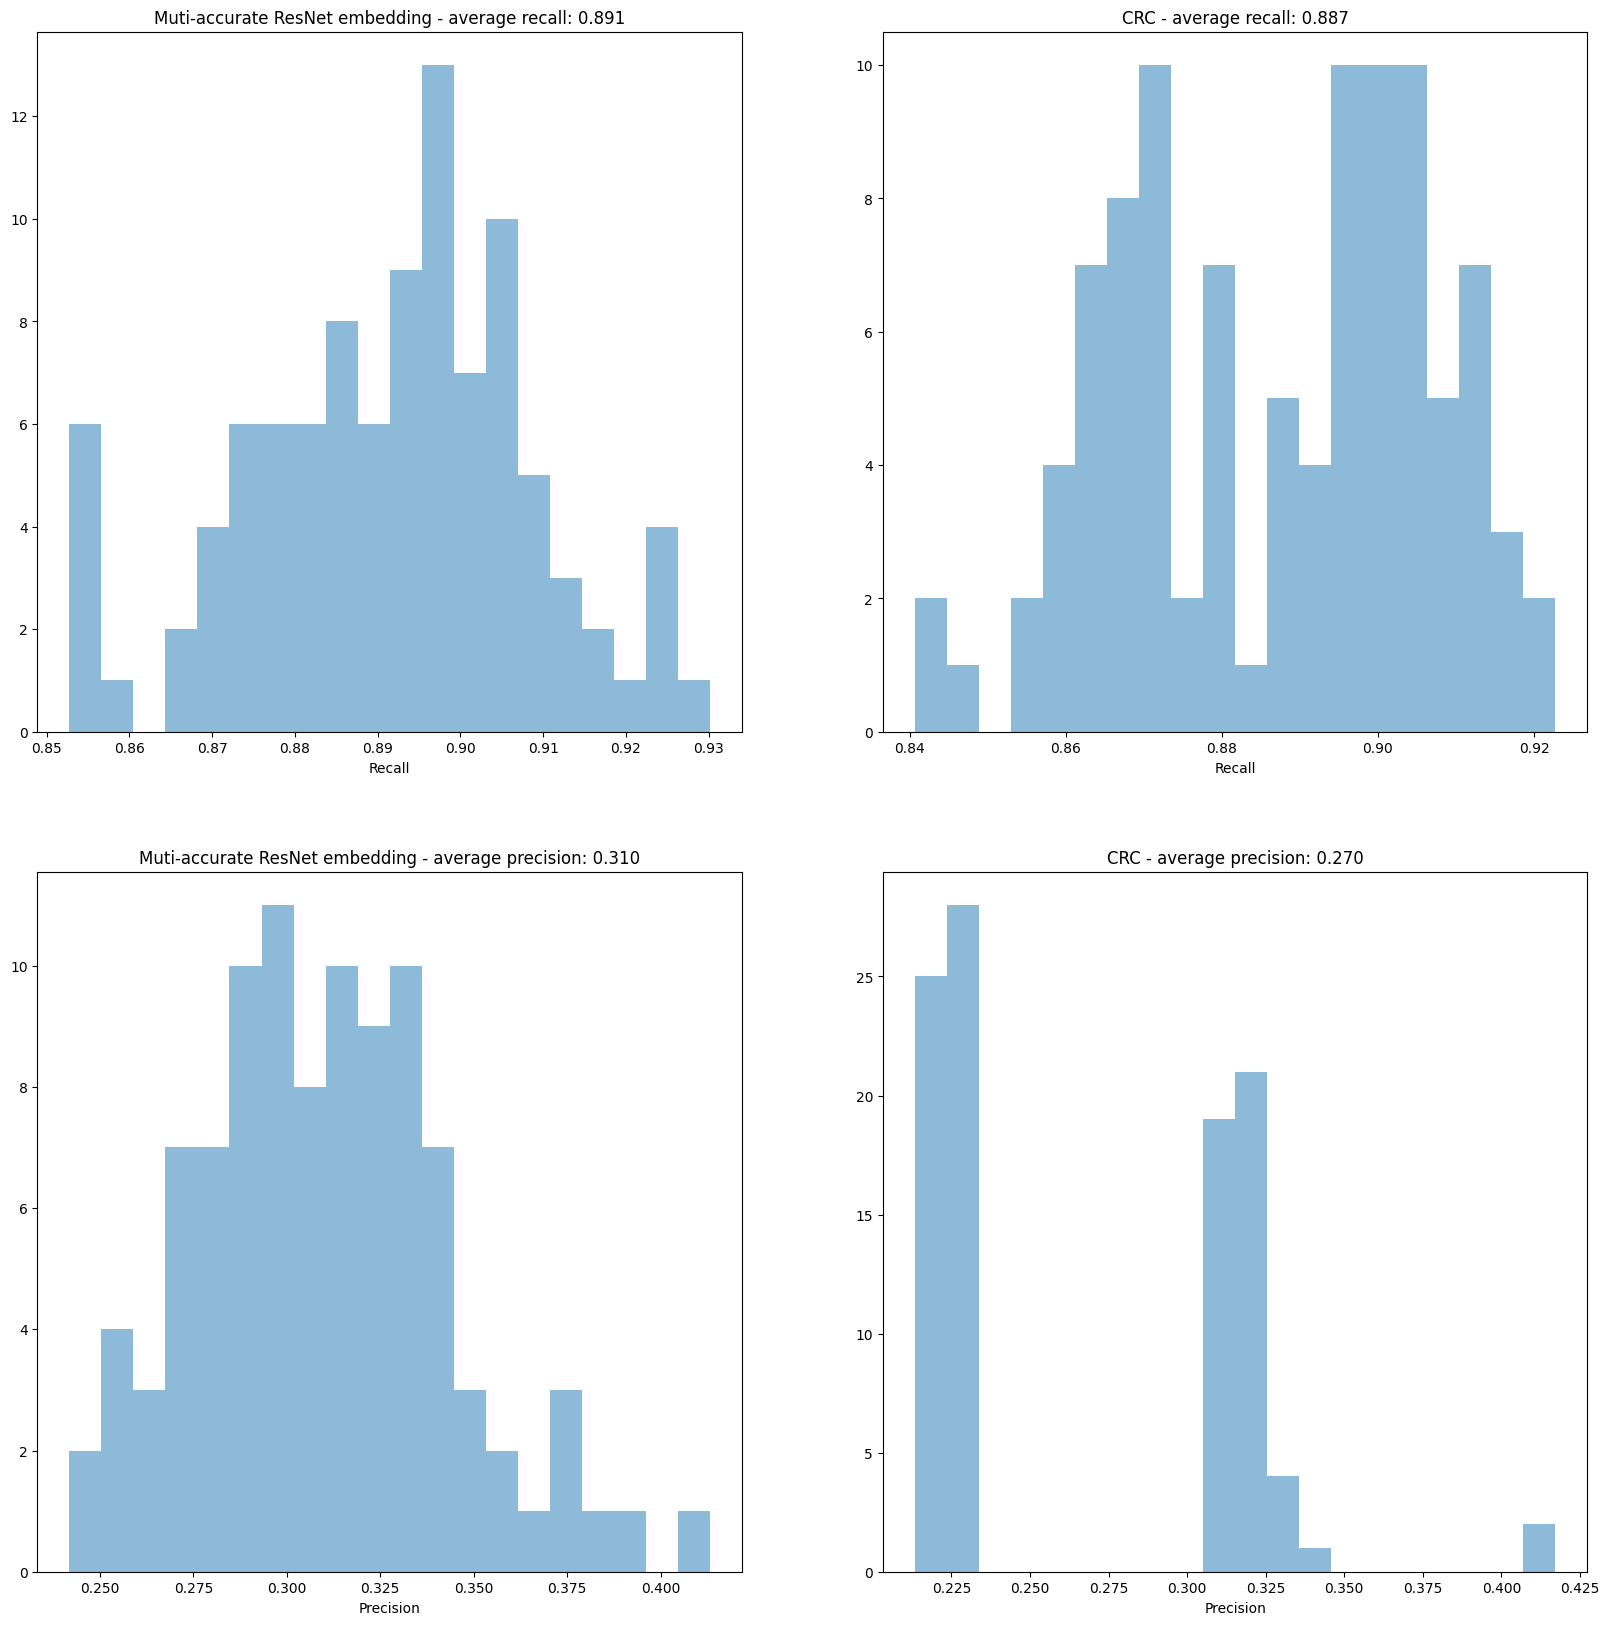

In [ ]:
s = 10
nrow = 2
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))

nbins = 20
ax[0, 0].hist(recalls_resnet, bins=nbins, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recalls_resnet):.3f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recalls_crc, bins=nbins, alpha=.5)
ax[0, 1].set_title(f"CRC - average recall: {np.nanmean(recalls_crc):.3f}")
ax[0, 1].set_xlabel("Recall")

ax[1, 0].hist(precisions_resnet, bins=nbins, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precisions_resnet):.3f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precisions_crc, bins=nbins, alpha=.5)
ax[1, 1].set_title(f"CRC - average precision: {np.nanmean(precisions_crc):.3f}")
ax[1, 1].set_xlabel("Precision")